In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import warnings
from pandas import Grouper
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMAResults 

In [2]:
series = pd.read_csv('champagne.csv', index_col = 0, header = 0, squeeze = True, parse_dates = True)

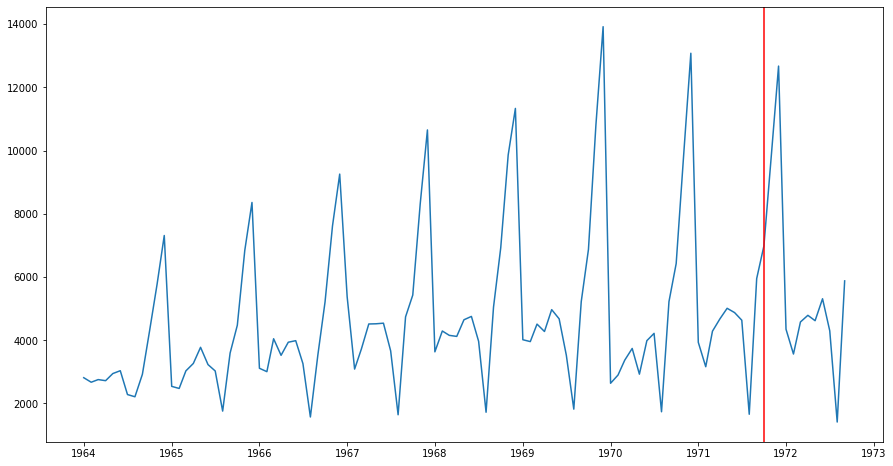

In [20]:
plt.figure(figsize = (15,8))
plt.plot(series)
plt.axvline(x= '1971-09-30', color= 'red')
plt.show()

In [147]:
dataset, validation = series[ : len(series)-12], series[len(series)-12 : ]

# Persistence Model

In [35]:
train_size = int(len(dataset) * 0.5)
X = dataset.values
X = X.astype('float32')
train, test = X[0:train_size],X[train_size:] 
history = [x for x in train]

predictions = []

for t in range(len(test)):
    y_hat = history[-1]
    observation = test[t]
    predictions.append(y_hat)
    history.append(observation)
    
    print("Predicted Value", y_hat, "Actual Value", observation)
rmse = math.sqrt(mean_squared_error(test, predictions))    
print("Persistence RMSE", rmse, sep =  " : ")

Predicted Value 5428.0 Actual Value 8314.0
Predicted Value 8314.0 Actual Value 10651.0
Predicted Value 10651.0 Actual Value 3633.0
Predicted Value 3633.0 Actual Value 4292.0
Predicted Value 4292.0 Actual Value 4154.0
Predicted Value 4154.0 Actual Value 4121.0
Predicted Value 4121.0 Actual Value 4647.0
Predicted Value 4647.0 Actual Value 4753.0
Predicted Value 4753.0 Actual Value 3965.0
Predicted Value 3965.0 Actual Value 1723.0
Predicted Value 1723.0 Actual Value 5048.0
Predicted Value 5048.0 Actual Value 6922.0
Predicted Value 6922.0 Actual Value 9858.0
Predicted Value 9858.0 Actual Value 11331.0
Predicted Value 11331.0 Actual Value 4016.0
Predicted Value 4016.0 Actual Value 3957.0
Predicted Value 3957.0 Actual Value 4510.0
Predicted Value 4510.0 Actual Value 4276.0
Predicted Value 4276.0 Actual Value 4968.0
Predicted Value 4968.0 Actual Value 4677.0
Predicted Value 4677.0 Actual Value 3523.0
Predicted Value 3523.0 Actual Value 1821.0
Predicted Value 1821.0 Actual Value 5222.0
Predict

# Data Analysis

In [36]:
dataset.describe()

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
Name: Sales, dtype: float64

### Line Plot

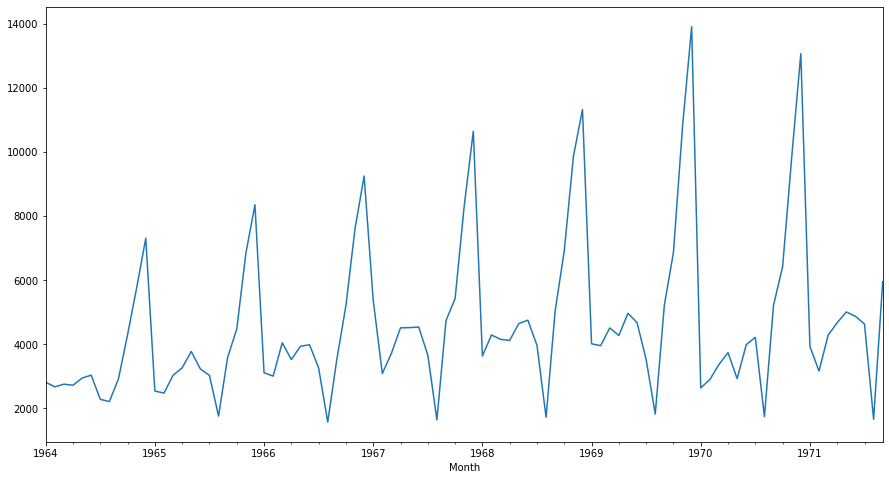

In [58]:
plt.figure(figsize = (15,8))
dataset.plot()
plt.show()

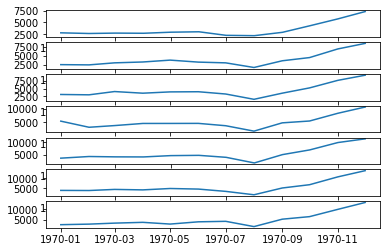

In [51]:
groups = dataset['1964':'1970'].groupby(Grouper(freq = 'A'))
plt.figure()
i = 1
n_groups = len(groups)

years = pd.DataFrame()
# plt.figure(figsize = (15,8))
for name,group in groups:
    plt.subplot((n_groups)*100 + 10 + i)

    i = i+1
    plt.plot(group)
plt.show()    

### Density Plot

<Figure size 432x288 with 0 Axes>

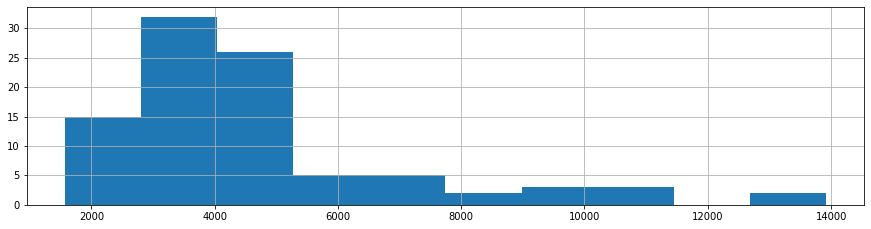

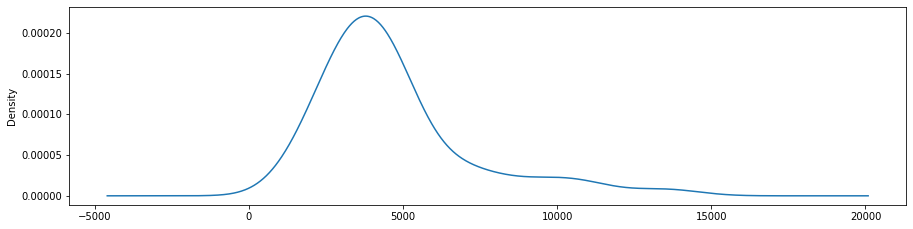

In [57]:

plt.figure(1)
plt.figure(figsize = (15,8))
plt.subplot(211)
dataset.hist()
plt.show()
plt.figure(figsize = (15,8))
plt.subplot(212)
dataset.plot(kind = 'kde')
plt.show()

### Observation  :  The shape has a long right tail and may suggest an exponential distribution

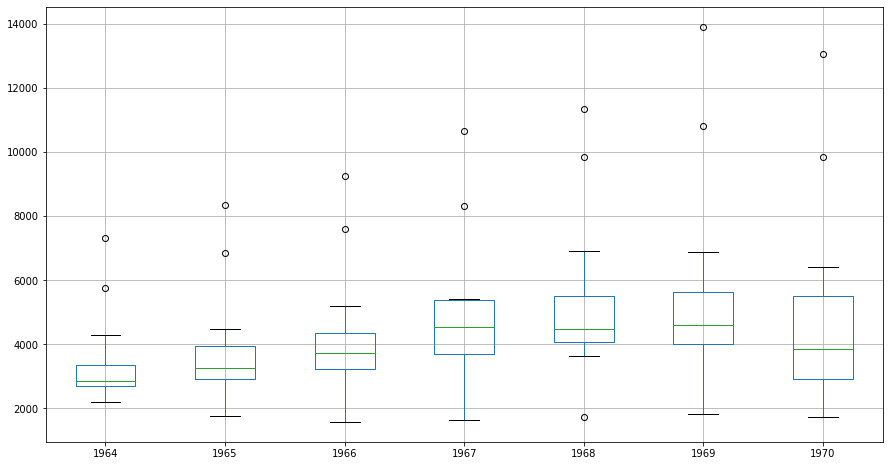

In [59]:
plt.figure(figsize = (15,8))
groups = dataset['1964':'1970'].groupby(Grouper(freq = 'A'))
years = pd.DataFrame()
for name,group in groups:
    years[name.year] = group.values
years.boxplot()
plt.show()

### Observation  :

 - There are outliers each year
 - The median valye seems to be rising each year
 - the last year 1970 seems different from all other years



# Arima Model

In [69]:
def difference(dataset, interval = 1):
    X = dataset.values
    X = X.astype('float32')
    
    differenced = [X[i] - X[i-interval] for i in range(interval, len(X))]
    return pd.Series(differenced)

seasonality = 12
seasoned_data = difference(dataset, seasonality)

result = adfuller(seasoned_data)
print("ADF Statistic",result[0], sep = " : ")
print("p Value",result[1], sep = " : ")
for key,value in result[4].items():
    print(key,value,sep = " : ")



ADF Statistic : -7.134898152961878
p Value : 3.441293677009898e-10
1% : -3.5148692050781247
5% : -2.8984085156250003
10% : -2.58643890625


### Observation : 

Since the ADF Statistic is less than the significance values, we can reject the null hypothesis at 1% level of significance and this essentially means that the time series is stationary and does not have a temporal structure

[]

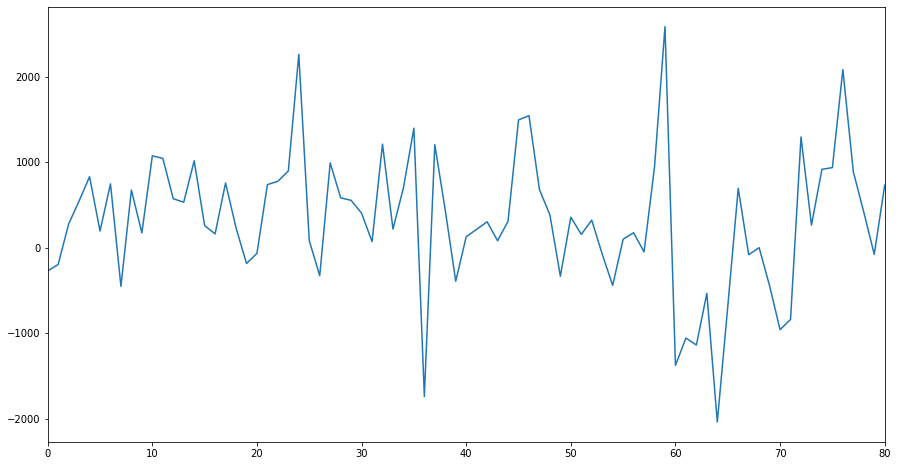

In [71]:
plt.figure(figsize = (15,8))
seasoned_data.plot()
plt.plot()

# Looking At Autocorrelation and Partial Autocorrelation Plots

 - This essentially given the value ranges for p,d,q

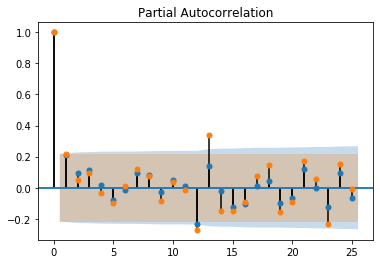

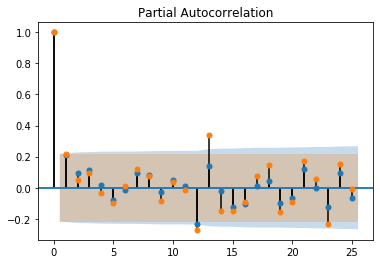

In [79]:
plot_acf(seasoned_data, lags = 25, ax=plt.gca())
plot_pacf(seasoned_data, lags = 25, ax=plt.gca())

In [91]:
def difference(history, interval = 1):
 
    differenced = [history[i] - history[i-interval] for i in range(interval, len(history))]
    return pd.Series(differenced)

In [92]:
def inverse_difference(y_hat, history, interval = 1):
    return y_hat + history[-interval]

In [97]:
def evaluate_arima(dataset, arima_order):
    X = dataset.values
    X = X.astype('float32')
    
    train_size = int(len(X) * 0.5)
    train_set, test_set = X[0:train_size], X[train_size : ]
    
    history = [x for x in train_set]
    predictions = []
    for t in range(len(test_set)):
        interval = 12
        differenced = difference(history, interval)

        model = ARIMA(differenced, arima_order)
        model_fit = model.fit(trend='nc', disp = 0)
        y_hat = model_fit.forecast()[0]
        y_hat = inverse_difference(y_hat, history, interval)
        observation = test[t]
        #print("Predicted", observation, "Actual", y_hat, sep = " : ")
        predictions.append(y_hat)
        history.append(observation)
    rmse = math.sqrt(mean_squared_error(test_set, predictions))
    
    print("Manual ARIMA RMSE", rmse, sep = " : ")

In [98]:
evaluate_arima(dataset, (1,1,1))

Manual ARIMA RMSE : 956.9468750621537


### Observation  : 

RMSE value for manual ARIMA is less than that of persistence model

### Grid Search ARIMA

In [101]:
def difference(history, interval = 1):
 
    differenced = [history[i] - history[i-interval] for i in range(interval, len(history))]
    return pd.Series(differenced)

In [102]:
def inverse_difference(y_hat, history, interval = 1):
    return y_hat + history[-interval]

In [109]:
def evaluate_arima(dataset, arima_order):
    X = dataset.values
    X = X.astype('float32')
    
    train_size = int(len(X) * 0.5)
    train_set, test_set = X[0:train_size], X[train_size : ]
    
    history = [x for x in train_set]
    predictions = []
    for t in range(len(test_set)):
        interval = 12
        differenced = difference(history, interval)

        model = ARIMA(differenced, arima_order)
        model_fit = model.fit(trend='nc', disp = 0)
        
        y_hat = model_fit.forecast()[0]
        y_hat = inverse_difference(y_hat, history, interval)
        
        observation = test[t]
        #print("Predicted", observation, "Actual", y_hat, sep = " : ")
        predictions.append(y_hat)
        history.append(observation)
    rmse = math.sqrt(mean_squared_error(test_set, predictions))
    
    return rmse

In [112]:
def make_arima_model(dataset, p_range, d_range, q_range):    
    best_rmse, best_config = float('inf'), None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    rmse = evaluate_arima(dataset, (p,d,q))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_config = (p,d,q)
                    print("Model RMSE", rmse, "At Config", (p,d,q), sep = " : ")
                except:
                    continue
    print("Best RMSE", best_rmse, "Best Config", best_config,sep = " : ")

In [113]:
p_range = range(0,7)
d_range = range(0,3)
q_range = range(0,7)
warnings.filterwarnings("ignore")
make_arima_model(dataset, p_range, d_range, q_range)

Model RMSE : 939.464170137107 : At Config : (0, 0, 1)
Model RMSE : 962.2893172433423 : At Config : (0, 0, 2)
Model RMSE : 944.2373707916853 : At Config : (0, 0, 3)
Model RMSE : 958.7866328429288 : At Config : (0, 0, 4)
Model RMSE : 986.8330166718041 : At Config : (0, 0, 5)
Model RMSE : 1087.008108086023 : At Config : (0, 0, 6)
Model RMSE : 958.3003313790559 : At Config : (0, 1, 1)
Model RMSE : 1146.9869849847646 : At Config : (0, 2, 1)
Model RMSE : 944.4487725481728 : At Config : (1, 0, 0)
Model RMSE : 1070.2039071388235 : At Config : (1, 1, 0)
Model RMSE : 956.9468750621537 : At Config : (1, 1, 1)
Model RMSE : 1555.8582253163863 : At Config : (1, 2, 0)
Model RMSE : 955.1340300274459 : At Config : (2, 0, 0)
Model RMSE : 948.6856130349255 : At Config : (2, 0, 1)
Model RMSE : 1030.4669163586252 : At Config : (2, 1, 0)
Model RMSE : 980.9624298122686 : At Config : (2, 1, 1)
Model RMSE : 1346.597781780365 : At Config : (2, 2, 0)
Model RMSE : 1039.6398016663609 : At Config : (2, 2, 1)
Model 

### Observation : Tuning the Hyperparameters of the model tells us that the model performed relatively better at (4,0,1) configuration : RMSE - 913.2377

# Looking at Residual Errors

In [114]:
def difference(history, interval = 1):
 
    differenced = [history[i] - history[i-interval] for i in range(interval, len(history))]
    return pd.Series(differenced)

In [115]:
def inverse_difference(y_hat, history, interval = 1):
    return y_hat + history[-interval]

In [117]:
def evaluate_arima(dataset, arima_order):
    X = dataset.values
    X = X.astype('float32')
    
    train_size = int(len(X) * 0.5)
    train_set, test_set = X[0:train_size], X[train_size : ]
    
    history = [x for x in train_set]
    predictions = []
    for t in range(len(test_set)):
        interval = 12
        differenced = difference(history, interval)

        model = ARIMA(differenced, arima_order)
        model_fit = model.fit(trend='nc', disp = 0)
        
        y_hat = model_fit.forecast()[0]
        y_hat = inverse_difference(y_hat, history, interval)
        
        observation = test[t]
        #print("Predicted", observation, "Actual", y_hat, sep = " : ")
        predictions.append(y_hat)
        history.append(observation)
    rmse = math.sqrt(mean_squared_error(test_set, predictions))
    residuals = [test_set[t] - predictions[t] for t in range(len(test_set))]
    print("Tuned ARIMA RMSE", rmse, sep  = " : ")
    return residuals

In [118]:
residuals = evaluate_arima(dataset, (4,0,1))

Tuned ARIMA RMSE : 913.2377623561746


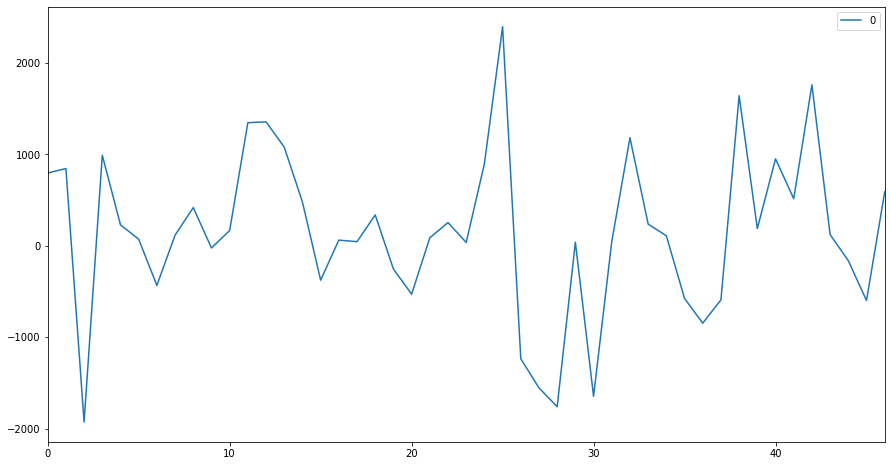

In [125]:
residuals = pd.DataFrame(residuals)
residuals.plot(figsize = (15,8))
plt.show()

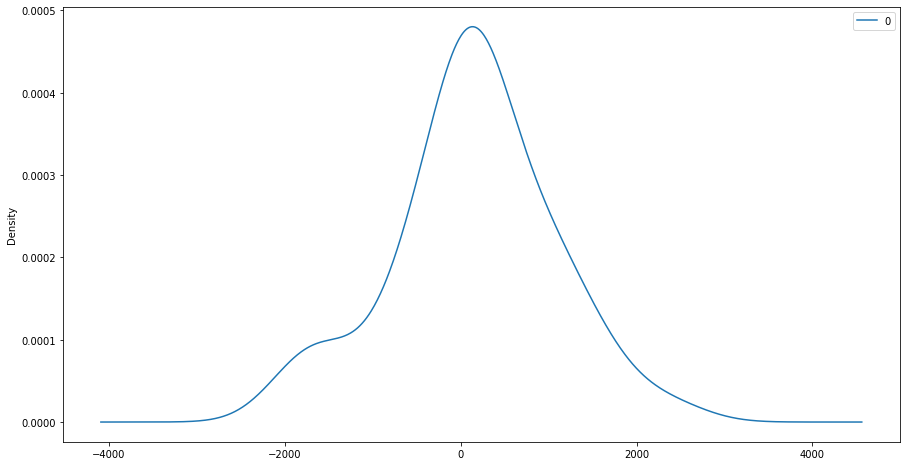

In [128]:
residuals.plot(kind = 'kde', figsize = (15,8))

### Observation : 

The KDE plot of the residuals shows a gaussian like distribution with a bumpy left tail. Thus a power transform using boxcox could be helpful ( would be explored later )

In [126]:
residuals.describe()

,0
count,47.000000
mean,146.961624
std,911.079843
min,-1928.268517
25%,-314.654554
50%,116.540483
75%,693.509153
max,2398.505895


### Observation : The Average Residual Error is 146.961624, so we add it to our predictions to correct for bias

In [129]:
def difference(history, interval = 1):
 
    differenced = [history[i] - history[i-interval] for i in range(interval, len(history))]
    return pd.Series(differenced)

In [130]:
def inverse_difference(y_hat, history, interval = 1):
    return y_hat + history[-interval]

In [137]:
def evaluate_arima(dataset, arima_order):
    X = dataset.values
    X = X.astype('float32')
    
    train_size = int(len(X) * 0.5)
    train_set, test_set = X[0:train_size], X[train_size : ]
    
    history = [x for x in train_set]
    predictions = []
    bias = 146.961624
    for t in range(len(test_set)):
        interval = 12
        differenced = difference(history, interval)

        model = ARIMA(differenced, arima_order)
        model_fit = model.fit(trend='nc', disp = 0)
        
        y_hat = model_fit.forecast()[0]
        y_hat = bias + inverse_difference(y_hat, history, interval)
        
        observation = test[t]
        #print("Predicted", observation, "Actual", y_hat, sep = " : ")
        predictions.append(y_hat)
        history.append(observation)
    rmse = math.sqrt(mean_squared_error(test_set, predictions))
    residuals = [test_set[t] - predictions[t] for t in range(len(test_set))]
    print("Bias Corrected Tuned ARIMA RMSE", rmse, sep  = " : ")
    return residuals

In [138]:
residuals = pd.DataFrame(evaluate_arima(dataset, (4,0,1)))

Bias Corrected Tuned ARIMA RMSE : 901.3353934896138


In [139]:
residuals.describe()

,0
count,4.700000e+01
mean,3.658042e-07
std,9.110798e+02
min,-2.075230e+03
25%,-4.616162e+02
50%,-3.042114e+01
75%,5.465475e+02
max,2.251544e+03


# Model Validation

In [140]:
X[1]

-197.0

### Saving the Model

In [145]:
X = dataset.values
X = X.astype('float32')

interval = 12
differenced = difference(X, interval)
bias = 146.961624
model = ARIMA(differenced, (4,1,0))
model_fit = model.fit(trend = 'nc', disp = 0)
model_fit.save('model_fit.pkl')
np.save('bias.npy', bias)

### Loading and  Validation

In [164]:
X = dataset.values
X = X.astype('float32')

y = validation.values
y = y.astype('float32')
predictions = []
history = [x for x in X]
model_fit = model_fit.load('model_fit.pkl')
bias = np.load('bias.npy')

y_hat = float(model_fit.forecast()[0])
y_hat = bias + inverse_difference(y_hat, history, interval)
predictions.append(y[0])
history.append(y_hat)
print("Predicted Value", y_hat, "Actual Value", y[0], sep = " : ")
for t in range(1, len(y)):
    differenced = difference(history, interval)
    
    model = ARIMA(differenced, (4,1,0))
    
    model_fit = model.fit(trend = 'nc', disp = 0)
    
    y_hat = float(model_fit.forecast()[0])
    
    y_hat = bias + inverse_difference(y_hat, history, interval)
    
    observation = y[t]
    
    predictions.append(observation)
    history.append(y_hat)
    
    print("Predicted Value", y_hat, "Actual Value", observation, sep = " : ")
rmse = math.sqrt(mean_squared_error(y, predictions))
print("Validated RMSE", rmse, sep = " : ")


Predicted Value : 7216.630062341979 : Actual Value : 6981.0
Predicted Value : 10524.68540221286 : Actual Value : 9851.0
Predicted Value : 13822.459504955359 : Actual Value : 12670.0
Predicted Value : 4751.33417882596 : Actual Value : 4348.0
Predicted Value : 4071.029387135633 : Actual Value : 3564.0
Predicted Value : 5250.371025766248 : Actual Value : 4577.0
Predicted Value : 5692.261939438838 : Actual Value : 4788.0
Predicted Value : 6091.6866936361785 : Actual Value : 4618.0
Predicted Value : 6019.962551521685 : Actual Value : 5312.0
Predicted Value : 5841.902778131775 : Actual Value : 4298.0
Predicted Value : 2929.813828880518 : Actual Value : 1413.0
Predicted Value : 7284.099635291863 : Actual Value : 5877.0
Validated RMSE : 0.0


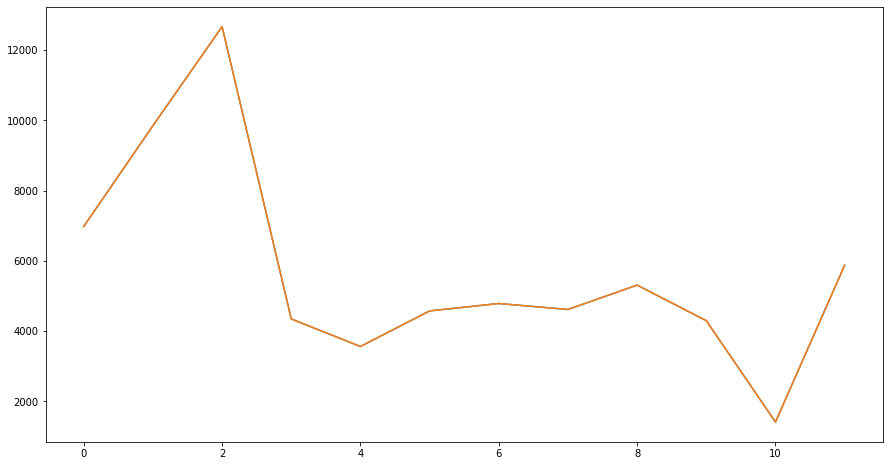

In [167]:
plt.figure(figsize = (15,8))
plt.plot(y)
plt.plot(predictions)
plt.show()